<a href="https://colab.research.google.com/github/Aadarsh-Praveen/Food101/blob/main/Food101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Checking GPU



In [ ]:
!nvidia-smi

Thu Sep 18 18:39:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   35C    P0             56W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# Import the Dataset

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
list_datasets = tfds.list_builders()

In [ ]:
target_dataset = "food101"
print(f"Is {target_dataset} in the list of datasets? {target_dataset in list_datasets}")

Is food101 in the list of datasets? True


## Load in the Dataset

In [ ]:
(train_data, test_data), ds_info = tfds.load(name=target_dataset,
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True,
                                             download=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.Z0GR9U_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.Z0GR9U_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names[:20]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla']

In [ ]:
len(class_names)

101

### View the data

In [ ]:
one_sample = train_data.take(1)

In [ ]:
one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image, label in one_sample:
  print(f"ImageShape: {image.shape}")
  print(f"Label: {label}")
  print(f"Label Name: {class_names[label]}")

ImageShape: (384, 512, 3)
Label: 97
Label Name: takoyaki


# Preprocess the Data

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
image.shape, image.dtype

(TensorShape([384, 512, 3]), tf.uint8)

In [ ]:
for image, label in one_sample:
  print(image.shape)
  print(image.dtype)
  print(class_names[label])

(512, 512, 3)
<dtype: 'uint8'>
grilled_cheese_sandwich


#### Preprocessing the shape and the data type

In [ ]:
def preprocess_image(image, label, shape=224):
  image = tf.image.resize(image,[shape, shape])
  tf.cast(image, tf.float32)
  return image, label

#### Batch and prepare datasets

In [ ]:
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
test_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

#### Setup mixed precision training to increase the speed

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

## Building feature extraction model


In [ ]:
# Create Base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
#View the model
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
# The efficientnet model has an inbuilt rescaling layer
input=layers.Input(shape=(224,224,3), name="input_layer")
x=base_model(input, training=False)

# Global Average Pooling layer
x=layers.GlobalAveragePooling2D(name="pooling_layer")(x)

# Output Layer
x=layers.Dense(len(class_names))(x)
output=layers.Activation(activation="softmax", dtype=tf.float32, name="output_layer")(x)

# Build the model
model=tf.keras.Model(input, output)

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Define the directory name for logs and checkpoints
dir_name = "food101_experiments"
checkpoint_path = "food101_checkpoints.weights.h5"

In [ ]:
# Add callbacks (tensorbaord callback and model checkpoint callback)

# Tensorboard callback
import datetime
def tensorboard_callback(dir_name, experiment_name):
  log_dir=dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Modelcheckpoint callback
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor="val_accuracy", save_best_only=True, save_freq="epoch")

In [ ]:
# Fit the model
feature_extraction_history=model.fit(train_data,
                                     epochs=5,
                                     validation_data=test_data,
                                     validation_steps=int(0.15 * len(test_data)) ,
                                     callbacks=[tensorboard_callback(dir_name=dir_name, experiment_name="feature_extraction"),
                                                checkpoint_callback])

Saving TensorBoard log files to: food101_experiments/feature_extraction/20250918-184930
Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 134s 36ms/step - accuracy: 0.4599 - loss: 2.3570 - val_accuracy: 0.7026 - val_loss: 1.1573
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.6530 - loss: 1.3475 - val_accuracy: 0.7222 - val_loss: 1.0532
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.6912 - loss: 1.1837 - val_accuracy: 0.7323 - val_loss: 0.9981
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.7117 - loss: 1.1011 - val_accuracy: 0.7405 - val_loss: 0.9690
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.7255 - loss: 1.0384 - val_accuracy: 0.7405 - val_loss: 0.9644


In [ ]:
# Evaluate the model
y_pred=model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.7389 - loss: 0.9651


In [ ]:
y_pred

[0.9612646698951721, 0.7377029657363892]

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Activation)       │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,307,461 (24.06 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 258,768 (1010.82 KB)

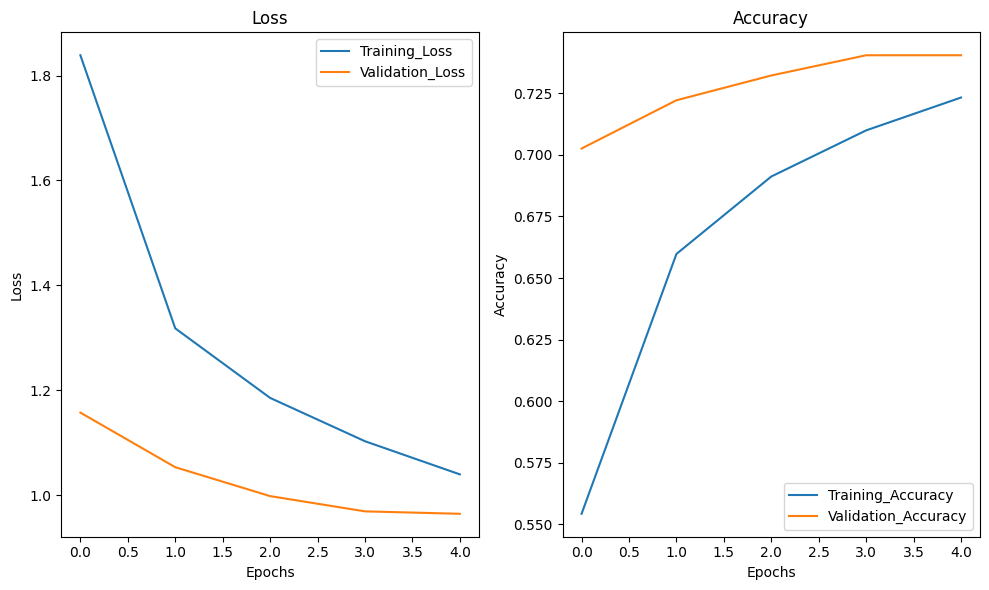

In [ ]:
# Plot the curves
import matplotlib.pyplot as plt
import numpy as np

loss=feature_extraction_history.history['loss']
val_loss=feature_extraction_history.history['val_loss']

accuracy=feature_extraction_history.history['accuracy']
val_accuracy=feature_extraction_history.history['val_accuracy']
epochs=range(len(feature_extraction_history.history["loss"]))

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
# Plot loss
plt.plot(epochs, loss, label="Training_Loss")
plt.plot(epochs, val_loss, label="Validation_Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
# Plot Accuracy
plt.plot(epochs, accuracy, label="Training_Accuracy")
plt.plot(epochs, val_accuracy, label="Validation_Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Fine Tuning the model

In [ ]:
load_weight=model.load_weights(checkpoint_path)

#### Fine tune the model for 10 layers

In [ ]:
# Fine tune the model by unfreezing the last 10 layers of the base model
base_model.trainable = True

# Unfreeze the last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
# Check the traiable layers
for i, layer in enumerate (base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
# Compile the model for fine-tuning
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Lower learning rate for fine-tuning
              metrics=["accuracy"])

In [ ]:
# Fit the model
fine_tune_epoch=10
fine_tune_history_10=model.fit(train_data,
                               epochs=fine_tune_epoch,
                               validation_data=test_data,
                               validation_steps=int(0.15 * len(test_data)),
                               initial_epoch=feature_extraction_history.epoch[-1],
                               callbacks=[tensorboard_callback(dir_name=dir_name, experiment_name="fine_tuning_10"),
                                          checkpoint_callback])

Saving TensorBoard log files to: food101_experiments/fine_tuning_10/20250918-185536
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 125s 35ms/step - accuracy: 0.7185 - loss: 1.1035 - val_accuracy: 0.7619 - val_loss: 0.8916
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.7558 - loss: 0.9371 - val_accuracy: 0.7741 - val_loss: 0.8356
Epoch 7/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.7702 - loss: 0.8675 - val_accuracy: 0.7773 - val_loss: 0.8171
Epoch 8/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.7866 - loss: 0.8082 - val_accuracy: 0.7871 - val_loss: 0.7971
Epoch 9/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.8001 - loss: 0.7602 - val_accuracy: 0.7868 - val_loss: 0.7842
Epoch 10/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.8095 - loss: 0.7248 - val_accuracy: 0.7855 - val_loss: 0.7776


In [ ]:
# Evaluate the whole test data set
y_fine_tune_10=model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7835 - loss: 0.7826


In [ ]:
y_fine_tune_10

[0.7809752225875854, 0.7829703092575073]

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Activation)       │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,470,821 (28.50 MB)

 Trainable params: 711,061 (2.71 MB)

 Non-trainable params: 5,337,632 (20.36 MB)

 Optimizer params: 1,422,128 (5.42 MB)

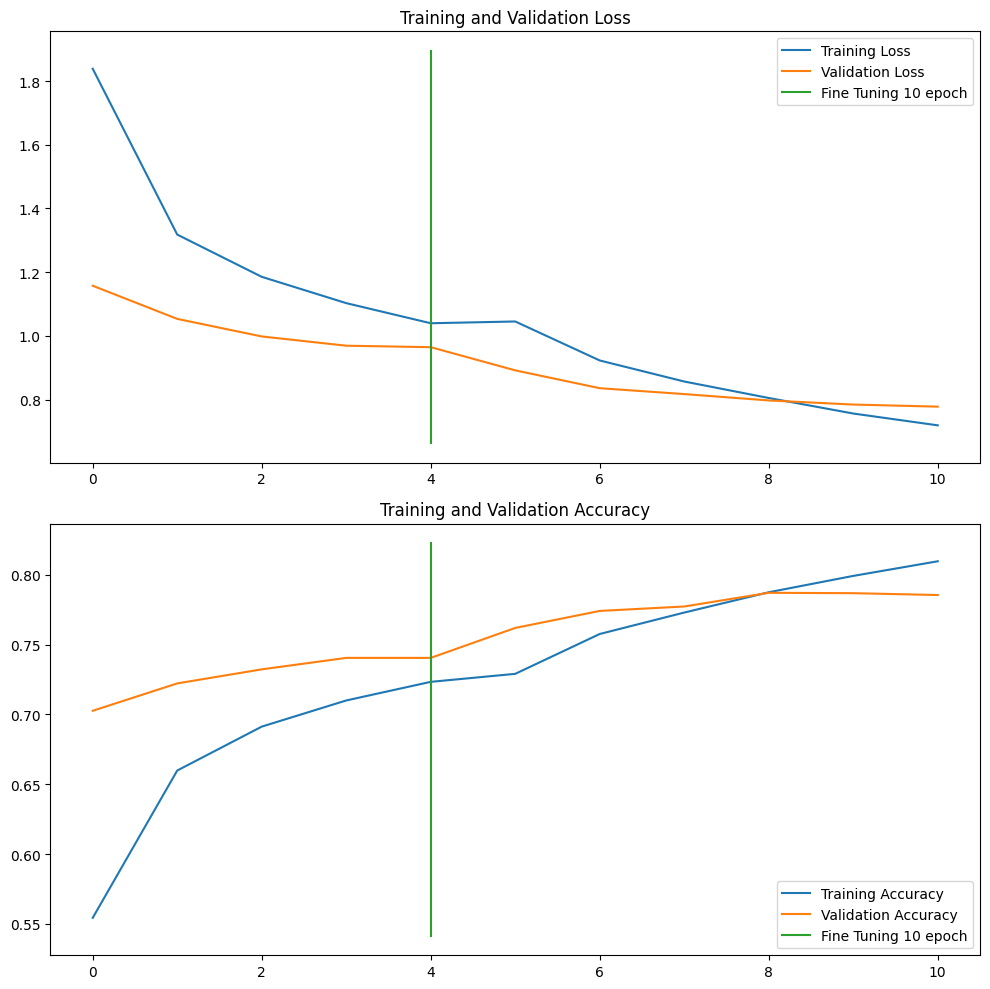

In [ ]:
# Plot the curves
loss=feature_extraction_history.history['loss']
val_loss=feature_extraction_history.history['val_loss']

accuracy=feature_extraction_history.history['accuracy']
val_accuracy=feature_extraction_history.history['val_accuracy']

# Combine original history with new history
total_accuracy = accuracy + fine_tune_history_10.history["accuracy"]
total_loss = loss + fine_tune_history_10.history["loss"]

total_val_accuracy = val_accuracy + fine_tune_history_10.history["val_accuracy"]
total_val_loss = val_loss + fine_tune_history_10.history["val_loss"]

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
# Plot loss
plt.plot(total_loss, label='Training Loss')
plt.plot(total_val_loss, label='Validation Loss')
plt.plot([5-1, 5-1],
plt.ylim(), label='Fine Tuning 10 epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
# Plot Accuracy
plt.plot(total_accuracy, label='Training Accuracy')
plt.plot(total_val_accuracy, label='Validation Accuracy')
plt.plot([5-1, 5-1],
plt.ylim(), label='Fine Tuning 10 epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.tight_layout()
plt.show()

### Fine tune the full model

In [ ]:
# Unfreeze the full model
base_model.trainable = True

for layer in base_model.layers:
  layer.trainable = True

In [ ]:
# Check the traiable layers
for i, layer in enumerate (base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_layer True
1 rescaling True
2 normalization True
3 stem_conv True
4 stem_bn True
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn True
8 block1a_project_activation True
9 block2a_expand_conv True
10 block2a_expand_bn True
11 block2a_expand_activation True
12 block2a_project_conv True
13 block2a_project_bn True
14 block2b_expand_conv True
15 block2b_expand_bn True
16 block2b_expand_activation True
17 block2b_project_conv True
18 block2b_project_bn True
19 block2b_drop True
20 block2b_add True
21 block3a_expand_conv True
22 block3a_expand_bn True
23 block3a_expand_activation True
24 block3a_project_conv True
25 block3a_project_bn True
26 block3b_expand_conv True
27 block3b_expand_bn True
28 block3b_expand_activation True
29 block3b_project_conv True
30 block3b_project_bn True
31 block3b_drop True
32 block3b_add True
33 block4a_expand_conv True
34 block4a_expand_bn True
35 block4a_expand_activation True
36 block4a_dwconv2 True
37 block4a_bn True
38 block4a_a

In [ ]:
checkpoint_path = "food101_checkpoints_full_fine_tune.weights.h5"

In [ ]:
# Add Earlystopping callback and checkpoint callback

# Earlystopping callback
early_stopping_callback=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

# Modelcheckpoint callback
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, save_freq="epoch")

In [ ]:
# Learning rate reduction callback
lr_reduce=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                               factor=0.2,
                                               patience=2,
                                               min_lr=1e-7,
                                               mode="max")

In [ ]:
# Compile the full model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
# Fit the model
fine_tune_full = model.fit(train_data,
                           epochs=50,
                           steps_per_epoch=len(train_data),
                           validation_data=test_data,
                           validation_steps=int(0.15 * len(test_data)),
                           callbacks=[tensorboard_callback(dir_name=dir_name, experiment_name="fine_tuning_full"),
                                      checkpoint_callback,
                                      early_stopping_callback,
                                      lr_reduce])


Saving TensorBoard log files to: food101_experiments/fine_tuning_full/20250918-190253
Epoch 1/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7029 - loss: 1.1115

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 448s 105ms/step - accuracy: 0.7029 - loss: 1.1114 - val_accuracy: 0.8109 - val_loss: 0.6633 - learning_rate: 1.0000e-04
Epoch 2/50
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8468 - loss: 0.5669

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 84s 35ms/step - accuracy: 0.8468 - loss: 0.5669 - val_accuracy: 0.8284 - val_loss: 0.6250 - learning_rate: 1.0000e-04
Epoch 3/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - accuracy: 0.8907 - loss: 0.4067 - val_accuracy: 0.8268 - val_loss: 0.6060 - learning_rate: 1.0000e-04
Epoch 4/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9298 - loss: 0.2712

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 84s 35ms/step - accuracy: 0.9298 - loss: 0.2712 - val_accuracy: 0.8326 - val_loss: 0.6180 - learning_rate: 1.0000e-04
Epoch 5/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9494 - loss: 0.2008

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 80s 34ms/step - accuracy: 0.9494 - loss: 0.2008 - val_accuracy: 0.8355 - val_loss: 0.6079 - learning_rate: 1.0000e-04
Epoch 6/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 80s 34ms/step - accuracy: 0.9650 - loss: 0.1456 - val_accuracy: 0.8355 - val_loss: 0.6381 - learning_rate: 1.0000e-04
Epoch 7/50
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9732 - loss: 0.1146

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - accuracy: 0.9732 - loss: 0.1146 - val_accuracy: 0.8419 - val_loss: 0.6348 - learning_rate: 1.0000e-04
Epoch 8/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 80s 34ms/step - accuracy: 0.9772 - loss: 0.0950 - val_accuracy: 0.8321 - val_loss: 0.6656 - learning_rate: 1.0000e-04
Epoch 9/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 80s 33ms/step - accuracy: 0.9812 - loss: 0.0801 - val_accuracy: 0.8289 - val_loss: 0.6705 - learning_rate: 1.0000e-04
Epoch 10/50
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9870 - loss: 0.0584

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 80s 34ms/step - accuracy: 0.9870 - loss: 0.0584 - val_accuracy: 0.8422 - val_loss: 0.6377 - learning_rate: 2.0000e-05
Epoch 11/50
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9913 - loss: 0.0432

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - accuracy: 0.9913 - loss: 0.0432 - val_accuracy: 0.8493 - val_loss: 0.6317 - learning_rate: 2.0000e-05
Epoch 12/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9930 - loss: 0.0353

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 85s 36ms/step - accuracy: 0.9930 - loss: 0.0353 - val_accuracy: 0.8496 - val_loss: 0.6297 - learning_rate: 2.0000e-05
Epoch 13/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 86s 36ms/step - accuracy: 0.9935 - loss: 0.0334 - val_accuracy: 0.8469 - val_loss: 0.6419 - learning_rate: 2.0000e-05
Epoch 14/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 86s 36ms/step - accuracy: 0.9949 - loss: 0.0291 - val_accuracy: 0.8469 - val_loss: 0.6314 - learning_rate: 2.0000e-05
Epoch 15/50
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9952 - loss: 0.0264

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 86s 36ms/step - accuracy: 0.9952 - loss: 0.0264 - val_accuracy: 0.8512 - val_loss: 0.6346 - learning_rate: 4.0000e-06
Epoch 16/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 86s 36ms/step - accuracy: 0.9961 - loss: 0.0249 - val_accuracy: 0.8509 - val_loss: 0.6320 - learning_rate: 4.0000e-06
Epoch 17/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 85s 36ms/step - accuracy: 0.9952 - loss: 0.0251 - val_accuracy: 0.8506 - val_loss: 0.6272 - learning_rate: 4.0000e-06
Epoch 18/50
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9957 - loss: 0.0228

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 85s 36ms/step - accuracy: 0.9957 - loss: 0.0228 - val_accuracy: 0.8517 - val_loss: 0.6355 - learning_rate: 8.0000e-07
Epoch 19/50
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9965 - loss: 0.0224

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 85s 36ms/step - accuracy: 0.9965 - loss: 0.0224 - val_accuracy: 0.8546 - val_loss: 0.6350 - learning_rate: 8.0000e-07
Epoch 20/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 84s 35ms/step - accuracy: 0.9963 - loss: 0.0223 - val_accuracy: 0.8501 - val_loss: 0.6357 - learning_rate: 8.0000e-07
Epoch 21/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 85s 36ms/step - accuracy: 0.9961 - loss: 0.0228 - val_accuracy: 0.8506 - val_loss: 0.6290 - learning_rate: 8.0000e-07
Epoch 22/50
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 85s 36ms/step - accuracy: 0.9960 - loss: 0.0232 - val_accuracy: 0.8535 - val_loss: 0.6263 - learning_rate: 1.6000e-07


In [ ]:
fine_tune_full=model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.8498 - loss: 0.6362


In [ ]:
fine_tune_full

[0.6323660016059875, 0.8493069410324097]

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Activation)       │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,024,869 (68.76 MB)

 Trainable params: 5,988,085 (22.84 MB)

 Non-trainable params: 60,608 (236.75 KB)

 Optimizer params: 11,976,176 (45.69 MB)

### Load the images and test the model performance

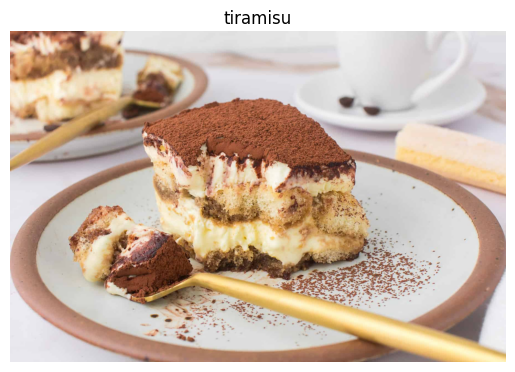

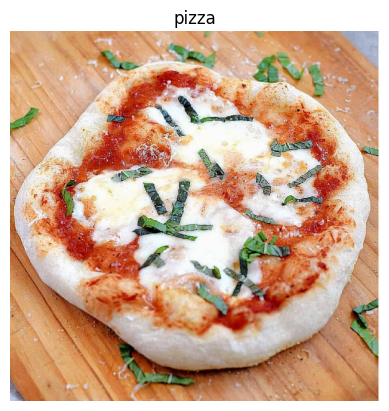

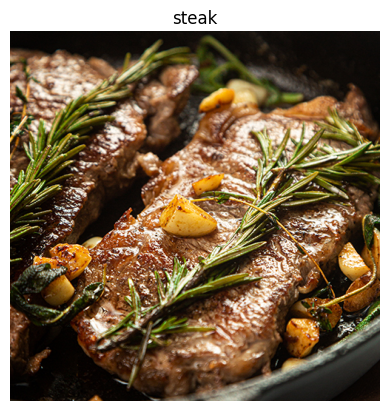

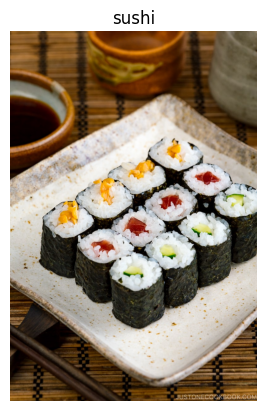

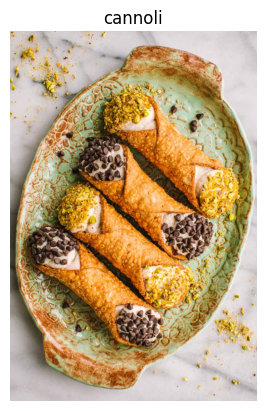

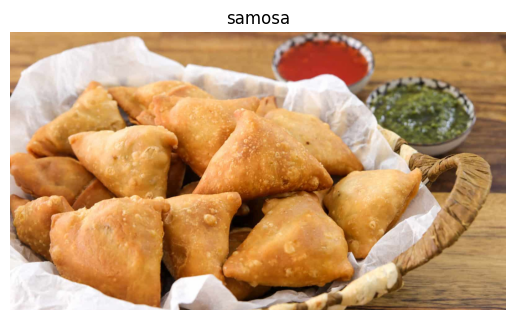

In [ ]:
import os
from tensorflow.keras.preprocessing import image

# Get class names from ds.info
class_names = ds_info.features["label"].names

folder_path = "/content/food_images"
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]


def load_and_prep_single_image(img_path, shape=224):
    img = tf.keras.utils.load_img(img_path, target_size=(shape, shape))
    img = tf.keras.utils.img_to_array(img)
    img = tf.cast(img, tf.float32)
    img = tf.expand_dims(img, axis=0)
    return img

for img_file in image_files:
    img_path = os.path.join(folder_path, img_file)
    x = load_and_prep_single_image(img_path)

    pred = model.predict(x, verbose=0)
    pred_idx = int(tf.argmax(pred[0]))
    label_name = class_names[pred_idx]

    plt.figure()
    plt.imshow(tf.keras.utils.load_img(img_path))
    plt.axis("off")
    plt.title(label_name)
    plt.show()
